In [212]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

teleFile = "https://raw.githubusercontent.com/AkeemSemper/ML_for_Non_DS_Students/06a7b1408c3342b5a5d5d792742fda0760c9a476/data/tele.csv"
salaryFile = "https://raw.githubusercontent.com/AkeemSemper/ML_for_Non_DS_Students/06a7b1408c3342b5a5d5d792742fda0760c9a476/data/salaries.csv"

# Grid Search and Model Improvements

When creating a predictive model, there are several things that we can try to maximize the performance of the model, making it as useful as possible. Some of the common things we can do include:
<ul>
    <li>Selecting a model type that "fits" the data well.  We'll explore different models soon. </li>
    <li>Get more or better data. This is often the most effective way to improve a model.</li>
    <li>Improve the data. This can involve cleaning, normalizing, or transforming the data.</li>
    <li>Improve the model by changing the hyperparameters that control it's creation - hyperparameter tuning. </li>
</ul>

Here, we'll focus on the last point - hyperparameter tuning. Specifically, we'll look at the tool that we normally use to conduct the hyperparameter tuning - a grid search.

## Defining a Good Fit

We will explore this concept more soon, but we can introduce a couple of very common terms we'll see when creating predictive models:
<ul>
    <li><b>Underfitting</b>: When a model is too simple to explain the variance in the data. It performs poorly on the training data and generalizes poorly to new data.</li>
    <li><b>Overfitting</b>: When a model is too complex and learns the detail and noise in the training data to the extent that it negatively impacts the performance on new data.</li>
</ul>

Our goal here is a model that provides a good balance - we need it to learn enough to make accurate predictions, but not so much that it is bad at making predictions on new data.

![Underfitting and Overfitting](../images/overfit_underfit.png "Underfitting and Overfitting")

In [213]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

df.drop(["mean fractal dimension", "worst fractal dimension", "texture error", 
         "smoothness error", "symmetry error", "fractal dimension error", 
         "concavity error", "compactness error", "concave points error",
         "perimeter error", "area error", "worst texture", "worst smoothness",
         "worst symmetry", "worst compactness", "worst concavity", "worst concave points"
         ], axis=1, inplace=True)

targ = pd.Series(data.target)

df["target"] = targ
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,radius error,worst radius,worst perimeter,worst area,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,1.0950,25.38,184.60,2019.0,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.5435,24.99,158.80,1956.0,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.7456,23.57,152.50,1709.0,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.4956,14.91,98.87,567.7,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.7572,22.54,152.20,1575.0,0


## Hyperparameters

Hyperparameters are the parameters that are not learned by the model. They are set before the training process, normally as argument that we can specify when we create the object. Hyperparameters are important because they directly control the behavior of the training algorithm and have a significant impact on the performance of the model. These are different from the regular 'parameters', which is another term for the things that a model can learn - the weights/coefficients/slopes/etc. that are updated as the model is trained.

![Hyperparameters](../images/hyperparameters.png "Hyperparameters")

### Selecting Hyperparameters

The hyperparameters can drastically impact the accuracy of a model, so one of the key things we can do is to try to select the best combination of hyperparameters for our scenario - a process called hyperparameter tuning. This process is simple at its core, we just need to test different combinations of hyperparameters and select the one that gives us the best results, as measured by whatever accuracy metric we are using.

<b>Note:</b> you can ignore the details of what the hyperparameters in this image are for now, these ones come from neural networks, but the idea is identical for any model.

![HP Tuning](../images/hp_tuning.webp "HP Tuning")

In [214]:
# Base model

X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_base = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression())
])

pipe_base.fit(X_train, y_train)
print("Base model accuracy: ", pipe_base.score(X_test, y_test))

Base model accuracy:  0.956140350877193


#### Logistic Regression Hyperparameters

Logistic regression (and linear regression) actually have fewer hyperparameters than many other models, but we can still try a few and observe the results. Some that we can test in our grid search are:
<ul>
    <li><b>penalty</b>: The norm used in the penalization. We can use 'l1' or 'l2'.</li>
    <li><b>C</b>: The inverse of regularization strength. Smaller values specify stronger regularization.</li>
    <li><b>fit_intercept</b>: Whether to calculate the intercept for this model. If set to False, no intercept will be used in calculations.</li>
</ul>

<b>Note:</b> The details of what these are not super critical at this point, they are things that we'll look at more soon. Regularization is a technique that is used to prevent overfitting by limiting the size of the coefficients, it is common. We will look at regularization more soon, but we can manipulate the HP to see the impacts on our model. The fit_intercept parameter is just whether the model is allowed to have a "b" parameter in the equation.

In [215]:
mod_test = LogisticRegression(penalty="l1", C=0.1, solver="liblinear", fit_intercept=False)

pipe_test = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", mod_test)
])

pipe_test.fit(X_train, y_train)

print("Test model accuracy: ", pipe_test.score(X_test, y_test))

Test model accuracy:  0.868421052631579


### Grid Search

We can automate much of the boring work in testing hyperparameters by using a technique called grid search. This technique is simple: we just specify a list of values for each hyperparameter we want to test, and the grid search will test all possible combinations of these values. Like Magic!

![Grid Search](../images/grid.png "Grid Search")

#### Using a Grid Search

We can use the GridSearchCV class to do this. We just need to specify the model we want to use, and the hyperparameters we want to test. The grid options are named using the convention nameOfObject__nameOfHyperparameter, with a double underscore separating the two. Where the nameOfObject is the name of that thing in the pipeline or column transformer that we provided, and the nameOfHyperparameter is the argument from that object. 

<b>Note:</b> the n_jobs=-1 argument tells the grid search to use all available cores on our machine to do the computation. 

In [216]:
param_grid = {
    "model__penalty": ["l1", "l2"],
    "model__C": np.logspace(-4, 4, 20),
    "model__solver": ["liblinear", "saga"],
    "model__fit_intercept": [True, False]
}

grid_pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression(max_iter=10000))
])

grid = GridSearchCV(grid_pipe, param_grid, cv=5, n_jobs=-1)

grid.fit(X_train, y_train)
best_params = grid.best_params_
print("Best parameters: ", best_params)
print("Best score: ", grid.best_score_)
print("Test model accuracy: ", grid.score(X_test, y_test))

Best parameters:  {'model__C': 206.913808111479, 'model__fit_intercept': True, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best score:  0.9670329670329669
Test model accuracy:  0.9824561403508771


#### Grid Search Results

We can access some of the internal results of the grid search to see what the best hyperparameters were, and what the best score was. The attributes are listed on the sklearn documentation, and we can access them using the . notation. Note that these kinds of outputs from the sklearn library can be in a variety of formats, including dictionaries, lists, and numpy arrays - often with several potential layers of nesting. And those data structures may have varying levels of user friendliness. Getting the results out and using them can be annoying the first time, but they are the same each time going forward, so most of the code can be copied. Going one step further, this is one scenario where looking up code examples online can be very helpful. Someone has already written how to extract all these results into a nice format, we just need to adapt it to our specific scenario.

In [217]:
grid.best_params_

{'model__C': 206.913808111479,
 'model__fit_intercept': True,
 'model__penalty': 'l1',
 'model__solver': 'liblinear'}

#### Prepare the Best Model

Once the grid search is complete, we can use the best_estimator_ attribute to get the best model. We can then use this model to make predictions as normal.

In [218]:
best_model = grid.best_estimator_
best_model

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=206.913808111479, max_iter=10000,
                                    penalty='l1', solver='liblinear'))])

## Cross Validation

When checking performance of a model, we always take a step to do the train-test split in the data, giving us one set of data used to create a model, and another set to test that model's accuracy on. This split in the data can have random variations though - what if the split randomly breaks up the data in a way that is not representative of the data as a whole? Or a way that puts a group of similar data all in the training set or the testing set. If we randomly break data into two groups, those groups aren't assured to both be similar and representative of the data as a whole. Usually they will be, but it varies - especially with small datasets.

A solution to this is relatively simple, we just do the split multiple times, and average the results of all the trials. This is called cross validation. The most common form of cross validation is k-fold cross validation, where we split the data into k groups, and then use each group as the testing set in turn, with the rest of the data as the training set. We then average the results of all the trials to get a final accuracy score.

![Cross Validation](../images/cross_val.jpg "Cross Validation")

### Using Cross Validation

In most cases, 5 to 10 folds are used for the cross validation calculations. The grid search will do cross validation as part of its process, but we can also call the cross_val_score function to do it directly, much like the score function. Be aware that this will perform each potential model in the grid search on each fold of the cross validation, so it can be a very computationally expensive process if the data is large or the model is complex.

<Axes: ylabel='Count'>

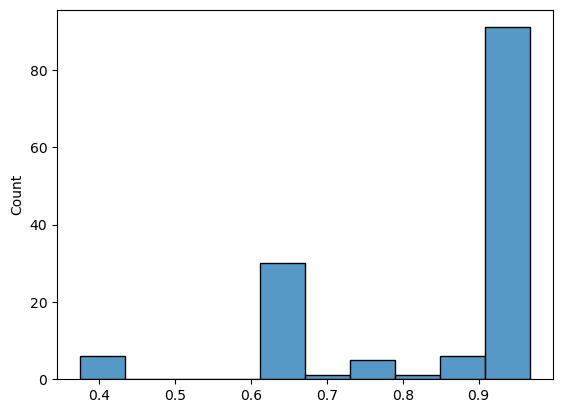

In [219]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

cv_params = {
    "model__penalty": ["l1", "l2"],
    "model__C": np.logspace(-4, 4, 20),
    "model__solver": ["liblinear", "saga", "lbfgs", "newton-cg", "sag"],
}

cv_pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression(max_iter=10000))
])

cv_grid = GridSearchCV(cv_pipe, cv_params, cv=30, n_jobs=-1)
cv_grid.fit(X, y)

cv_scores = cv_grid.cv_results_["mean_test_score"]
sns.histplot(cv_scores, kde=False, bins=10)

#### Cross Validation Score Function

We can also use cross_val_score to get the cross validation score directly, anywhere that we'd use the score function to get the accuracy of a model. We can specify the number of folds to use, as well as the scoring metric to calculate. Note that we'll get back a list of scores, one for each fold, so if we want to summarize the results, we need to calculate the mean of the scores.

This works for any model, classification or regression, as well as with any scoring metric.

In [220]:
vals = cross_val_score(best_model, X, y, cv=10, scoring="f1")
print("F1 Scores: ", vals)
print("Mean: ", np.mean(vals))

F1 Scores:  [0.97142857 0.95774648 0.98630137 0.97222222 0.98630137 0.97222222
 0.97297297 0.94444444 1.         0.97058824]
Mean:  0.9734227887183818


### Example with Column Transformer

We can also do a more complex and realistic example, with mixed feature necessitating a column transformer. 

#### Alternate Evaluation Metrics

By default, the grid search will use the default evaluation metric for the model we are using. For logistic regression, this is the mean accuracy. We can specify a different metric if we want to. For example, if we are looking for a model that is less likely to miss things like fraud detection, we can use f1 (or almost anything we can imagine) as the key metric.

The process of using the grid search does not change, but the model that is selected as the best will be based on whatever metric we specify instead of the regular accuracy. Note that if we are doing this with classification, we should also probably look at the accuracy and the confusion matrix as we did before - there's still risk to blindly trusting one metric, especially if we have data with an imbalance or if the impacts of false positives and false negatives are very different.

##### Data - Predict the Survival of Titanic Passengers

In [221]:
df_ct = sns.load_dataset("titanic")
df_ct.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


#### Grid Search with Column Transformer Template

The example below can be adapted to most of the problems you may encounter, with small changes. 

When using a column transformer or a large pipeline, it is common that we may have scenarios where we want to try different hyperparameters in things other than the final estimator (model). For example, we could use different imputation strategies and compare the results of mean vs median. In more complex examples later, we may have steps that do other types of data processing that we may want to test different hyperparameters for, such as removing the less useful features or simplifying the data to remove noise or speed processing. 

A grid search can be adapted to do the searching on any arguments in any step in our pipeline, we just need to specify the name of the step and the hyperparameter we want to test. 

#### Deeper Options in Grid Search

The model is normally at the "top level" of the layers of pipelines and transformers in a more complex column transformer setup. To get to things that are embedded in more than one pipeline, we can just specify it by name with a double underscore between each object. For example, in the bottom row of the grid search we have options to change the imputer strategy for the numeric pipeline. To address that option, we have several layers in the addressing - first to look inside the column transformer "ct", then to look inside the numeric pipeline "num", and finally to look inside the imputer "imputer_num".

This addressing scheme is somewhat annoying to use, but not that complex once you get used to it. We always need to refer to an option in the grid search by the name supplied in the pipeline or column transformer - if that option is inside more than one, then we need to work our way down through the layers, with a double underscore between each layer.

In [241]:
y_ct = df_ct["survived"]
X_ct = df_ct.drop("survived", axis=1)

num_cols = X_ct.select_dtypes(include=np.number).columns
cat_cols = X_ct.select_dtypes(include="object").columns

num_pipe = Pipeline([
    ("imputer_num", SimpleImputer()),
    ("scaler", MinMaxScaler())
])

cat_pipe = Pipeline([
    ("imputer_cat", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder())
])

ct = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

ct_params = {
    "model__penalty": ["l1", "l2"],
    "model__C": np.logspace(-4, 4, 20),
    "model__solver": ["liblinear", "saga", "lbfgs", "newton-cg", "sag"],
    "ct__num__imputer_num__strategy": ["mean", "median", "most_frequent"],
}

ct_pipe = Pipeline([
    ("ct", ct),
    ("model", LogisticRegression(max_iter=10000))
])

ct_grid = GridSearchCV(ct_pipe, ct_params, cv=5, n_jobs=-1, scoring="f1")
ct_grid.fit(X_ct, y_ct)

print("Best parameters: ", ct_grid.best_params_)
print("Best score: ", ct_grid.best_score_)

Best parameters:  {'ct__num__imputer_num__strategy': 'mean', 'model__C': 0.012742749857031334, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best score:  1.0


## Grid Search in Practice

The grid search is a simple way to find the best combination of hyperparameters from a list we define. In some cases though, we may not really know exactly what we should be trying in the first place. If we combine this with models that have lots of potential hyperparameter options, and datasets that are large and complex, we may end up with a huge number of combinations to try in our search for a good model. This can be computationally expensive, and time consuming.

There are several grid search-like techniques that can help by working through different HP options like a grid search, but with some more smarts behind the logic, to try to find the best options more quickly. These include:
<ul>
    <li>RandomizedSearchCV</li>
    <li>Bayesian Optimization</li>
    <li>Genetic Algorithms</li>
</ul>

We will not cover these in this notebook, but they are things to think about if you keep going with machine learning. Each of these has its own strengths and weaknesses, but they all attempt to help find a good HP combinations without needing to work through massive numbers of trials. Outside of that, they are just like a grid search.

It sounds kind of weird, but trial and error is a large part of machine learning, especially as things get more and more complex. We only have a rough idea of which model types, hyperparameters, and other options will work well for a given problem, and we don't actually know until we try it. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# The halving ones require an option to be enabled. 
#from sklearn.model_selection import HalvingGridSearchCV
#from sklearn.model_selection import HalvingRandomSearchCV


IN_COLAB = 'google.colab' in str(get_ipython())

## Exercise - Create a Model with Grid Search

Predict the target variable below. Use some of the hyperparameters that are available in the logistic regression model, from the class documentation page. Observe the best results, then try with some other accuracy metric outside of regular accuracy.

In [ ]:
if IN_COLAB:
    #pass
    !wget https://raw.githubusercontent.com/AkeemSemper/ML_for_Non_DS_Students/06a7b1408c3342b5a5d5d792742fda0760c9a476/data/tele.csv
    df_class = pd.read_csv("tele.csv")
else:
    df_class = pd.read_csv("../data/tele.csv")
    
df_class.rename(columns={"gender":"target"}, inplace=True)
df_class.head()

,region,tenure,age,marital,address,income,ed,employ,retire,target,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


##### Actually... Some of Those Numbers May Be Categories...

## Exercise - Regression with Grid Search

In this example try to predict the target. 

Use a SGDRegressor with a grid search to find the best hyperparameters. This model is a linear regression, but it uses gradient descent to find the best fit. Look up the documentation page for the model, grab some hyperparameters to test, and run some trials to see if you can find a good model. We will cover more on this model type soon. 

In processing the data, this dataset also has a few things that we can think about, they don't have one specific correct answer. For example, we'll have categories that have very uneven distributions. There are also categories with many different possible values, some very frequent and some occurring once. There are also columns that have data that is highly redundant with other columns. All of these things can be handled in a few different ways, and different solutions might be better for different problems. Try to think of a solution that can be logically supported - both in terms of what you know of predictive models, and of what you can think of from the real life problem. There aren't any specific skills or knowledge needed here beyond the basics, think about the goal and how each feature helps make that prediction. 

<b>Note:</b> all the dollar values are in USD now. The salary_currency column is their original currency. They are all converted to USD and can be directly compared in the target column. 

In [ ]:
# Use this type of model, it has more impactful hyperparameters
# Check the sklearn docs for the hyperparameter list. 
# We'll explore a bit more what they mean in about a week. 
from sklearn.linear_model import SGDRegressor
dummy_test_sgdr = SGDRegressor()

In [ ]:
if IN_COLAB:
    !wget https://raw.githubusercontent.com/AkeemSemper/ML_for_Non_DS_Students/06a7b1408c3342b5a5d5d792742fda0760c9a476/data/salaries.csv
    df_ex = pd.read_csv("salaries.csv")
    #pass
else:
    df_ex = pd.read_csv("../data/salaries.csv")

df_ex.rename(columns={"salary_in_usd": "target"}, inplace=True)
df_ex.drop("salary", axis=1, inplace=True)

df_ex.head()

,work_year,experience_level,employment_type,job_title,salary_currency,target,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,AI Engineer,USD,90000,AE,0,AE,L
1,2024,SE,FT,Machine Learning Engineer,USD,180500,US,0,US,M
2,2024,SE,FT,Machine Learning Engineer,USD,96200,US,0,US,M
3,2024,SE,FT,Machine Learning Engineer,USD,235000,AU,0,AU,M
4,2024,SE,FT,Machine Learning Engineer,USD,175000,AU,0,AU,M
